In [1]:
%load_ext lab_black
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_hdf("../data/observations.hdf", "key")
df.obs_rarity = df.obs_rarity.clip(1, 1)
df = df.groupby(["BU_NAAM", "year"]).sum()
df = df[df.obs_rarity > 0].sort_values("year")
df = df.obs_rarity.unstack("year")

df_norm = df / df.sum()
df_norm = df_norm.T

df_norm_wijk = df.T / df.T.mean()

df_evi = pd.read_csv("../data/satdata/evi.csv", index_col=0)
df_evi["year"] = df_evi.index.str.slice(0, 4)
df_evi_year = df_evi.groupby(df_evi.year).mean()
df_evi_year.index = df_evi_year.index.astype(int)
df_evi_year_change = df_evi_year.ffill().pct_change()

In [2]:
# heel lelijk
res = []
for (
    year,
    row,
) in (
    df.T.iterrows()
):  # itereer over df_norm (normalized per year (/ sum year)) of over df.T
    for wijk in row.keys():
        try:
            evi_val = df_evi_year.loc[int(year)][wijk]
        except Exception:
            continue
        res.append({"year": year, "wijk": wijk, "obs": row[wijk], "evi": evi_val})
df_res = pd.DataFrame(res)
df_res.head()

,year,wijk,obs,evi
0,2000,Bavel,1.0,3122.723835
1,2000,Belcrum,3.0,1568.098235
2,2000,Biesdonk,NaN,2401.087402
3,2000,Blauwe Kei,3.0,2229.858621
4,2000,Boeimeer,6.0,2437.546134


# Fauna observaties
De aanwezigheid van vogels en andere fauna in de buurt wijst niet alleen op een gezonde leefomgeving, maar brengt een wijk ook tot leven. Groen en fauna gaan hand in hand; hieronder laten we zien dat meer groen in een wijk meer dieren aantrekt.

Voor waarnemingen gebruiken we het aantal dier waarnemingen per wijk in een jaar, verzameld door de website [https://gbif.org](gbif.org)*.

Hieronder plotten we 5 wijken uit breda die de meeste fauna observaties hebben. Daarbij kijken we ook naar de variabele "evi" (de planten index), zodat per wijk duidelijk wordt wat de relatie is tussen hoe groen de wijk is, en hoe veel fauna observaties er zijn

\* De hele dataset is te downloaden op  https://doi.org/10.15468/dl.ub8wrd 

<Figure size 1152x360 with 0 Axes>

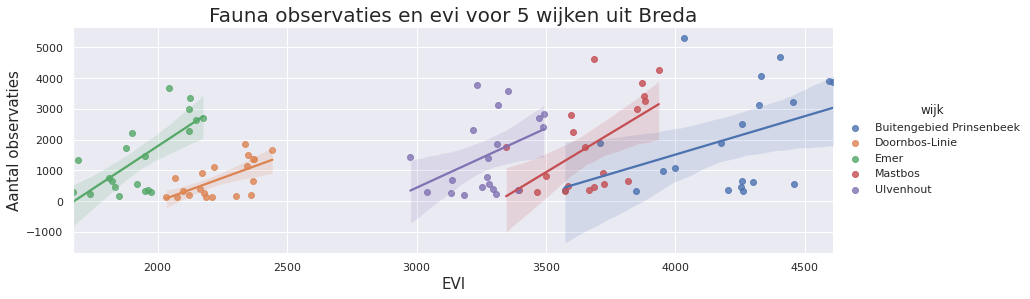

In [25]:
import seaborn as sns

wijken_veel_obs = [
    "Buitengebied Prinsenbeek",
    "Mastbos",
    "Ulvenhout",
    "Emer",
    "Doornbos-Linie",
]

sns.set()
plt.figure(figsize=(16, 5))

sns.lmplot(
    "evi",
    "obs",
    data=df_res[df_res.wijk.isin(wijken_veel_obs)],
    hue="wijk",
    height=4,
    aspect=3,
)
plt.title("Fauna observaties en evi voor 5 wijken uit Breda", fontsize=20)
plt.xlabel("EVI", fontsize=15)
plt.ylabel("Aantal observaties", fontsize=15)
plt.show()

## Dieper in de data

Een regressie model toont de relaties tussen fauna observaties aan een kant, en jaar, wijk en evi aan de andere kant. Zoals hieronder is te zien groeit het aantal observaties hard over de laatste 20 jaar - te verklaren door het populairder worden van het registreren van waarnemingen. Ook verschillen de aantal waarnemingen ook per wijk, de ene wijk is aantrekkelijker voor dieren dan de andere. Per wijk zal er ook verschil ziten in het aantal mensen wat waarnemingen registreert.

In [34]:
from statsmodels.formula.api import ols

df_res["evi_sq"] = df_res.evi ** 2
fit = ols("obs ~ evi + C(wijk) + C(year) ", data=df_res).fit()
# fit.summary()

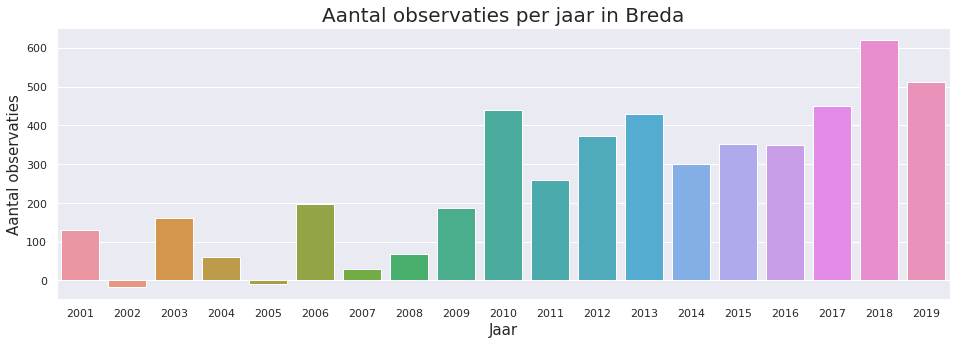

In [35]:
coefs = pd.Series(fit.params)
coefs_years = coefs[coefs.index.str.contains("year")]
years = coefs_years.index
years = [y.split(".")[1].replace("]", "") for y in years]


sns.set()
plt.figure(figsize=(16, 5))

sns.barplot(years, coefs_years.values)

plt.title("Aantal observaties per jaar in Breda", fontsize=20)
plt.xlabel("Jaar", fontsize=15)
plt.ylabel("Aantal observaties", fontsize=15)
plt.show()

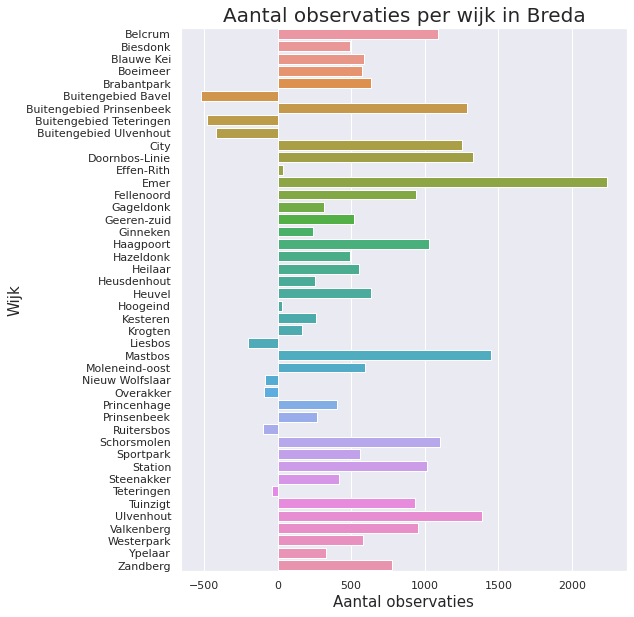

In [36]:
coefs = pd.Series(fit.params)
coefs_wijken = coefs[coefs.index.str.contains("wijk")]
wijken = coefs_wijken.index
wijken = [y.split("T.")[1].replace("]", "") for y in wijken]


sns.set()
plt.figure(figsize=(8, 10))

sns.barplot(coefs_wijken.values, wijken, orient="h")

plt.title("Aantal observaties per wijk in Breda", fontsize=20)
plt.xlabel("Aantal observaties", fontsize=15)
plt.ylabel("Wijk", fontsize=15)
plt.show()

## EVI

Na het "wegpoetsen" van de effecten van jaar en wijk op het aantal dierobservaties blijkt dat EVI een siginificant aandeel heeft. EVI heeft een coeficient van .6786 (p<0.000). Dat betekend dat een wijk met 1000 evi punten meer gemiddeld 68 waarnemingen per jaar meer heeft

In [37]:
fit = ols("obs ~ evi + C(wijk)  + C(year)", data=df_res).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    obs   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     18.70
Date:                Sun, 01 Nov 2020   Prob (F-statistic):          8.92e-110
Time:                        15:21:16   Log-Likelihood:                -5392.2
No. Observations:                 721   AIC:                         1.091e+04
Df Residuals:                     656   BIC:                         1.121e+04
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                           -2370.9633    574.909     -4.124      0.000   -3499.846   -1242.080
C(wijk)[T.Belcrum]                   1089.5262    306.044      3.560      0.000     488.583    1690.469
C(wijk)[T.Biesdonk]                   490.8588    323.425      1.518      0.130    -144.215    1125.932
C(wijk)[T.Blauwe Kei]                 583.9280    220.019      2.654      0.008     151.901    1015.955
C(wijk)[T.Boeimeer]                   574.1069    196.058      2.928      0.004     189.130     959.083
C(wijk)[T.Brabantpark]                631.6813    203.180      3.109      0.002     232.720    1030.643
C(wijk)[T.Buitengebied Bavel]        -520.4214    227.378     -2.289      0.022    -966.898     -73.944
C(wijk)[T.Buitengebied Prinsenbeek]  1288.6876    253.293      5.088      0.000     791.324    1786.051
C(wijk)[T.Buitengebied Teteringen]   -482.4349    203.226     -2.374      0.018    -881.488     -83.382
C(wijk)[T.Buitengebied Ulvenhout]    -417.4648    220.031     -1.897      0.058    -849.514      14.584
C(wijk)[T.City]                      1254.0938    343.202      3.654      0.000     580.186    1928.001
C(wijk)[T.Doornbos-Linie]            1325.0840    208.092      6.368      0.000     916.478    1733.690
C(wijk)[T.Effen-Rith]                  36.1648    214.718      0.168      0.866    -385.453     457.783
C(wijk)[T.Emer]                      2237.3168    248.212      9.014      0.000    1749.930    2724.704
C(wijk)[T.Fellenoord]                 939.2124    312.281      3.008      0.003     326.021    1552.404
C(wijk)[T.Gageldonk]                  314.5072    174.429      1.803      0.072     -27.999     657.014
C(wijk)[T.Geeren-zuid]                516.2657    237.988      2.169      0.030      48.955     983.576
C(wijk)[T.Ginneken]                   239.7228    154.694      1.550      0.122     -64.032     543.477
C(wijk)[T.Haagpoort]                 1030.0355    297.978      3.457      0.001     444.931    1615.140
C(wijk)[T.Hazeldonk]                  490.0736    152.359      3.217      0.001     190.904     789.243
C(wijk)[T.Heilaar]                    550.0322    203.218      2.707      0.007     150.997     949.068
C(wijk)[T.Heusdenhout]                251.8115    158.450      1.589      0.112     -59.319     562.942
C(wijk)[T.Heuvel]                     632.4075    207.147      3.053      0.002     225.656    1039.159
C(wijk)[T.Hoogeind]                    29.5873    152.743      0.194      0.846    -270.336     329.511
C(wijk)[T.Kesteren]                   259.9754    355.844      0.731      0.465    -438.755     958.705
C(wijk)[T.Krogten]                    168.9785    294.753      0.573      0.567    -409.794     747.751
C(wijk)[T.Liesbos]                   -203.9548    175.648     -1.16